In [1256]:
def plot_residuals(model):
	fitted = model.fittedvalues
	residuals = model.resid
	standardized_residuals = model.get_influence().resid_studentized_internal

	# Standardized Residuals Plot
	plt.figure(figsize = (8, 6))
	plt.scatter(fitted, standardized_residuals, color = "#1f2db0")
	plt.axhline(0, color = 'red', linestyle = '-')
	plt.axhline(2, color = 'green', linestyle = '--')
	plt.axhline(-2, color = 'green', linestyle = '--')
	plt.xlabel("Predicted y values")
	plt.ylabel("Standardied Residuals")
	plt.title('Standardized Residual Plot')


In [1257]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from scipy import stats
import seaborn as sns
import math

# 設定中文字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 設定支援中文的字型
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_budget'] > 10000000) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

In [1258]:
# 對 Type 進行前處理，僅留下 Drama, Comedy, Thriller_Suspense, Romaitic_Comedy
filtered_df = filtered_df[filtered_df['genre'].isin(['Drama', 'Comedy', 'Thriller/Suspense', 'Romantic Comedy'])]

In [1259]:
# 對 Source 進行前處理

filtered_df['source_category'] = (
    filtered_df['source'].apply(
        lambda x: 'Original Screenplay' if x == 'Original Screenplay' else 'Adapted'
    )
)

In [1260]:
# 前處理

filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
filtered_df["flattened_production_budget"] = np.pow(filtered_df["production_budget"], 1/4)
filtered_df["flattened_total_box_office"] = np.pow(filtered_df["total_box_office"], 1/4)
filtered_df["theatrical_engagements"] = np.pow(filtered_df["theatrical_engagements"], 1/2)
filtered_df['z_score'] = stats.zscore(filtered_df['flattened_total_box_office'])
filtered_df = filtered_df[filtered_df['z_score'].abs() <= 2].copy()


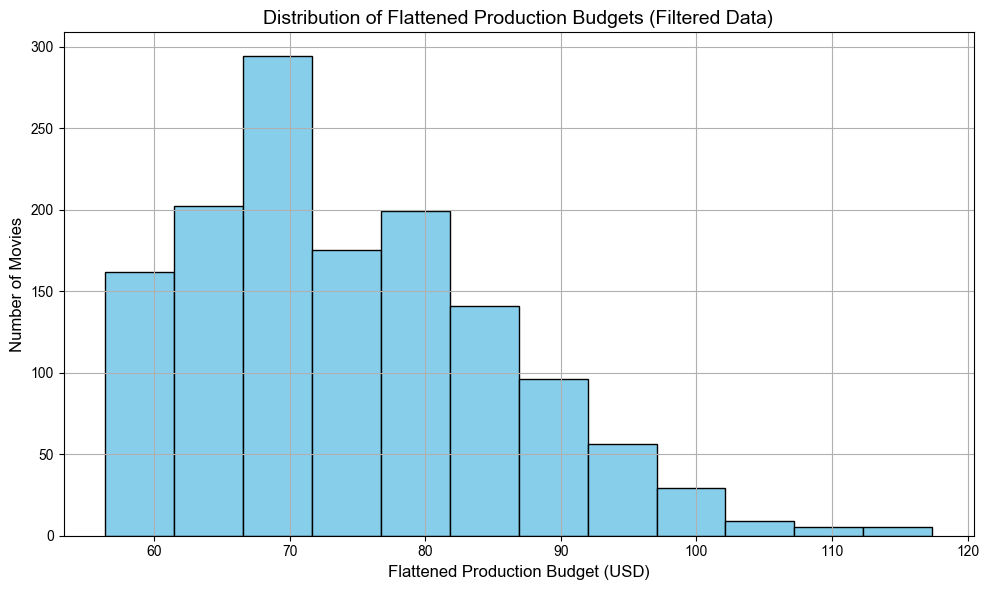

In [1261]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['flattened_production_budget'], bins=12, color='skyblue', edgecolor='black')
plt.title('Distribution of Flattened Production Budgets (Filtered Data)', fontsize=14)
plt.xlabel('Flattened Production Budget (USD)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [1262]:
# 計算 theatrical_engagements Q1 Q2 Q3
q1_engagement = filtered_df['theatrical_engagements'].quantile(0.25)
q2_engagement = filtered_df['theatrical_engagements'].quantile(0.50)
q3_engagement = filtered_df['theatrical_engagements'].quantile(0.75)
print(f"Q1: {q1_engagement}, Q2: {q2_engagement}, Q3: {q3_engagement}")

Q1: 71.84010022264724, Q2: 99.1766101457395, Q3: 122.20883765096532


In [1263]:
# 計算 flattened_production_budget Q1 Q2 Q3
q1_budget = filtered_df['flattened_production_budget'].quantile(0.25)
q2_budget = filtered_df['flattened_production_budget'].quantile(0.50)
q3_budget = filtered_df['flattened_production_budget'].quantile(0.75)
print(f"Q1: {q1_budget}, Q2: {q2_budget}, Q3: {q3_budget}")

Q1: 65.93491505914625, Q2: 72.74271525128259, Q3: 81.44476398584995


In [1264]:
# 計算 box_office Q1 Q2 Q3
q1_box_office = filtered_df['flattened_total_box_office'].quantile(0.25)
q2_box_office = filtered_df['flattened_total_box_office'].quantile(0.50)
q3_box_office = filtered_df['flattened_total_box_office'].quantile(0.75)
print(f"Q1: {q1_box_office}, Q2: {q2_box_office}, Q3: {q3_box_office}")

Q1: 68.1295113517851, Q2: 85.18232561374924, Q3: 101.71879708866332


In [1265]:
# 根據 creative_type 去建立 dummy variable
genre_dummy = pd.get_dummies(filtered_df["genre"].astype(str), prefix="T")
genre_dummy.columns = genre_dummy.columns.str.replace(' ', '_')
genre_dummy.columns = genre_dummy.columns.str.replace('/', '_')
genre_dummy = genre_dummy.drop(columns=["T_Drama"]) 
filtered_df = pd.concat([filtered_df, genre_dummy], axis=1)

source_dummy = pd.get_dummies(filtered_df["source_category"].astype(str), prefix="S")
source_dummy.columns = source_dummy.columns.str.replace(' ', '_')
source_dummy.columns = source_dummy.columns.str.replace('/', '_')
source_dummy.columns = source_dummy.columns.str.replace('-', '_')
source_dummy = source_dummy.drop(columns=["S_Original_Screenplay"]) 
filtered_df = pd.concat([filtered_df, source_dummy], axis=1)

In [1266]:
# 去把 budget 和 genre 做交乘
genre_budget_interaction = pd.DataFrame()
for genre in genre_dummy.columns:
    col_name = genre + "_budget_interaction"
    # 把開頭的 T 改成 I
    col_name = col_name.replace('T_', 'I_')
    genre_budget_interaction[col_name] = filtered_df['flattened_production_budget'] * filtered_df[genre]

# 增加 drama 和 budget 的交乘項，但因為沒有 T_Drama，所以用 1 - T_Comedy - T_Thriller_Suspense - T_Romantic_Comedy
genre_budget_interaction['I_Drama_budget_interaction'] = filtered_df['flattened_production_budget'] * (1 - filtered_df['T_Comedy'] - filtered_df['T_Thriller_Suspense'] - filtered_df['T_Romantic_Comedy'])
filtered_df = pd.concat([filtered_df, genre_budget_interaction], axis=1)


In [1267]:
# 去把 budget 和 source 做交乘
source_budget_interaction = pd.DataFrame()
for source in source_dummy.columns:
    col_name = source + "_budget_interaction"
    # 把開頭的 S 改成 I
    col_name = col_name.replace('S_', 'I_')
    source_budget_interaction[col_name] = filtered_df['flattened_production_budget'] * filtered_df[source]

source_budget_interaction['I_Original_Screenplay_interaction'] = filtered_df['flattened_production_budget'] * (1 - filtered_df['S_Adapted'])
filtered_df = pd.concat([filtered_df, source_budget_interaction], axis=1)


回歸分析結果摘要：
                                OLS Regression Results                                
Dep. Variable:     flattened_total_box_office   R-squared:                       0.287
Model:                                    OLS   Adj. R-squared:                  0.285
Method:                         Least Squares   F-statistic:                     110.2
Date:                        Wed, 11 Jun 2025   Prob (F-statistic):           5.82e-98
Time:                                17:05:41   Log-Likelihood:                -6060.1
No. Observations:                        1373   AIC:                         1.213e+04
Df Residuals:                            1367   BIC:                         1.216e+04
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
------------

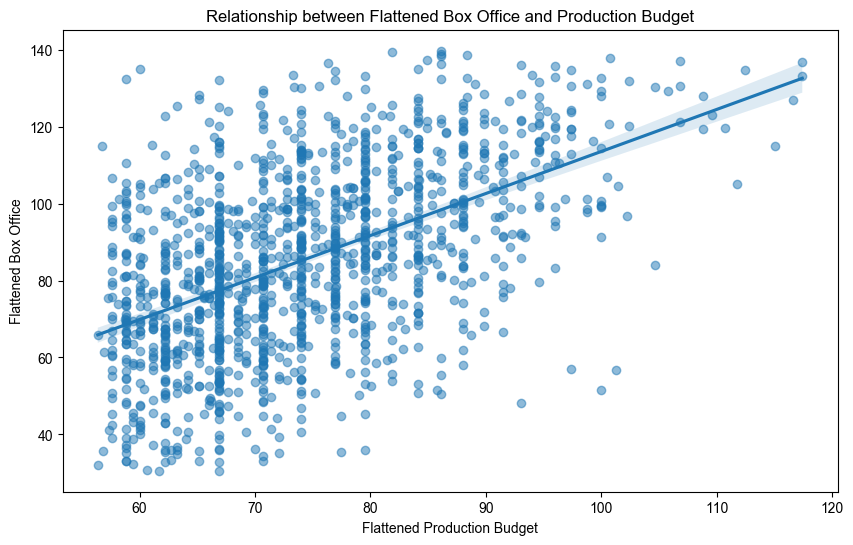

In [1268]:
model_formula = "flattened_total_box_office ~ flattened_production_budget"
# model_formula = model_formula + " + " + " + ".join(genre_dummy.columns)
model_formula = model_formula + " + " + " + ".join(source_dummy.columns)
model_formula = model_formula + " + " + " + ".join(genre_budget_interaction.columns)
# model_formula = model_formula + " + " + " + ".join(source_budget_interaction.columns)

# 執行回歸分析
model = sm.ols(formula=model_formula, data=filtered_df).fit()

# 印出回歸結果摘要
print("\n回歸分析結果摘要：")
print(model.summary())

# 繪製散點圖和回歸線
plt.figure(figsize=(10, 6))
sns.regplot(data=filtered_df, x='flattened_production_budget', y='flattened_total_box_office', scatter_kws={'alpha':0.5})
plt.title('Relationship between Flattened Box Office and Production Budget')
plt.xlabel('Flattened Production Budget')
plt.ylabel('Flattened Box Office')
# 畫出來
plt.show()

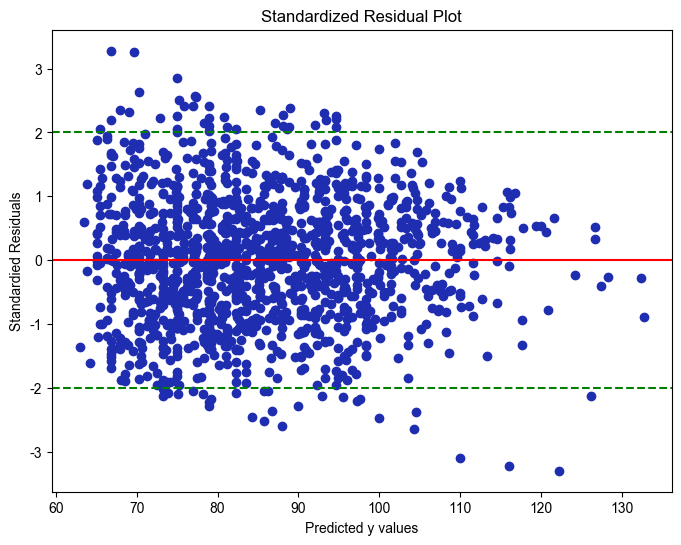

In [1269]:
plot_residuals(model)

                                OLS Regression Results                                
Dep. Variable:     flattened_total_box_office   R-squared:                       0.389
Model:                                    OLS   Adj. R-squared:                  0.386
Method:                         Least Squares   F-statistic:                     164.2
Date:                        Wed, 11 Jun 2025   Prob (F-statistic):          3.22e-135
Time:                                17:05:41   Log-Likelihood:                -5539.9
No. Observations:                        1297   AIC:                         1.109e+04
Df Residuals:                            1291   BIC:                         1.112e+04
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

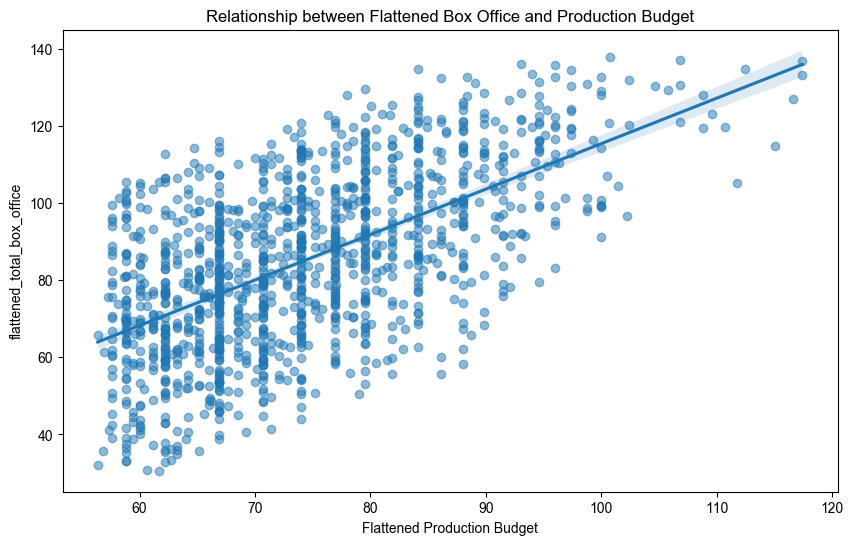

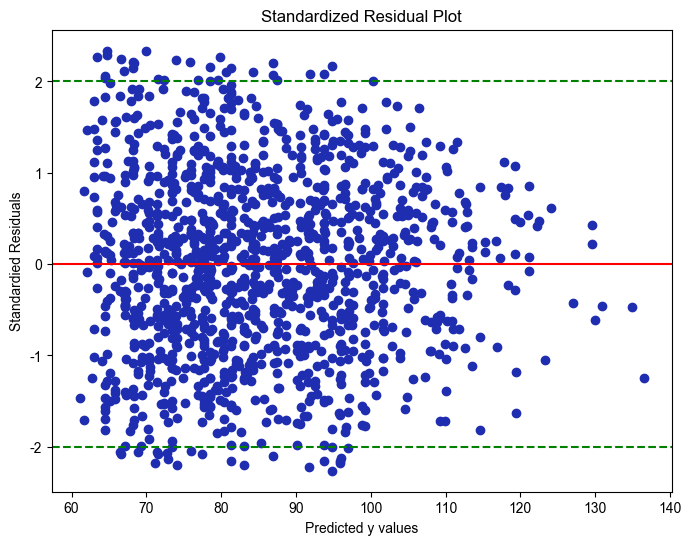

In [1270]:
# 去掉殘差與影響值過大的點

# Step 1：取得影響值與殘差
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
standard_resid = influence.resid_studentized_internal

# Step 2：設定門檻
cooks_thresh = 4 / len(filtered_df)
resid_thresh = 2 

# Step 3：留下正常觀測值
mask = (cooks_d < cooks_thresh) & (np.abs(standard_resid) < resid_thresh)
filtered_df = filtered_df[mask].copy()

# Step 4：重新建立模型
model = sm.ols(formula=model_formula, data=filtered_df).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.regplot(data=filtered_df, x='flattened_production_budget', y='flattened_total_box_office', scatter_kws={'alpha':0.5})
plt.title('Relationship between Flattened Box Office and Production Budget')
plt.xlabel('Flattened Production Budget')

plot_residuals(model)   

In [1271]:
def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    # Checking for start of new run
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        # no. of runs 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(l[i]) >= l_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = np.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

In [1272]:
# do the runs test on the residuals
residuals = model.resid.reset_index(drop=True)
median_residuals = np.median(residuals)
runsTest(residuals, median_residuals)


runs =  521
n1 =  649
n2 =  648
runs_exp =  649.4996144949885
stan_dev =  17.999983933155843
z =  -7.13887384412011
pval_z =  9.409864504753897e-13


np.float64(9.409864504753897e-13)

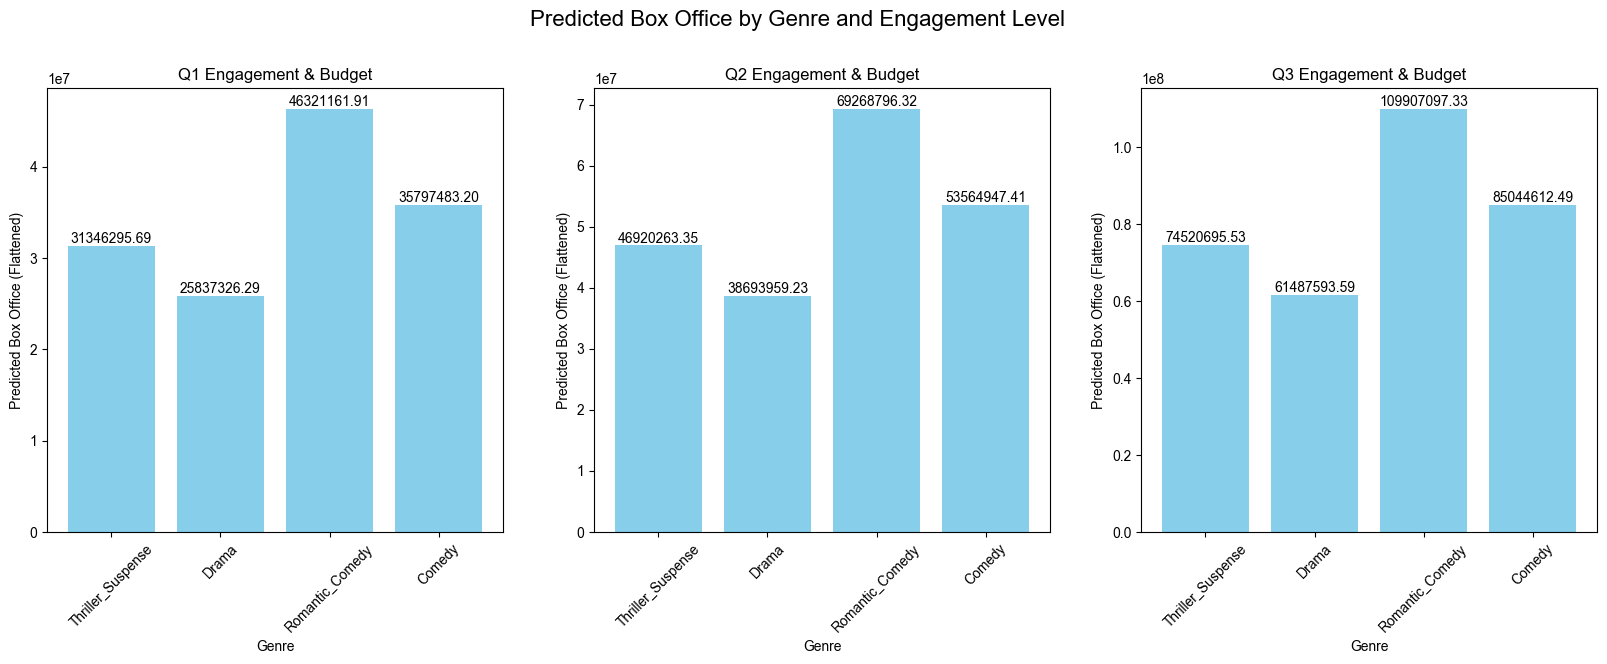

In [1273]:
def calculate_predictions(model, engagement, budget, genre):
    # 創建預測用的資料框
    pred_data = pd.DataFrame({
        'theatrical_engagements': [engagement],
        'flattened_production_budget': [budget],
        'S_Adapted': [0],  # 假設為 Adapted
        'I_Thriller_Suspense_budget_interaction': budget if genre == 'Thriller_Suspense' else 0,
        'I_Romantic_Comedy_budget_interaction': budget if genre == 'Romantic_Comedy' else 0,
        'I_Comedy_budget_interaction': budget if genre == 'Comedy' else 0,
        'I_Drama_budget_interaction': budget if genre == 'Drama' else 0,        
    })
    return model.predict(pred_data)[0]

# 為每種組合計算預測值
engagement_levels = ['Q1', 'Q2', 'Q3']
engagements = [q1_engagement, q2_engagement, q3_engagement]
budgets = [q1_budget, q2_budget, q3_budget]
genres = ['Thriller_Suspense', 'Drama', 'Romantic_Comedy', 'Comedy']

# 創建子圖
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Predicted Box Office by Genre and Engagement Level', fontsize=16)

for i, (engagement, budget, level) in enumerate(zip(engagements, budgets, engagement_levels)):
    predictions = []
    for genre in genres:
        pred = calculate_predictions(model, engagement, budget, genre)
        pred = np.power(pred, 4)
        predictions.append(pred)
    
    # 繪製長條圖
    # 把 x 軸的標籤改成 genre
    
    ax = axes[i]
    bars = ax.bar(genres, predictions, color='skyblue')
    ax.set_title(f'{level} Engagement & Budget')
    ax.set_xlabel('Genre')
    ax.set_ylabel('Predicted Box Office (Flattened)')
    ax.tick_params(axis='x', rotation=45)
    
    # 在長條上方添加數值標籤
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

plt.subplots_adjust(top=0.85)  # 調整上方空間以適應標題
plt.show() 

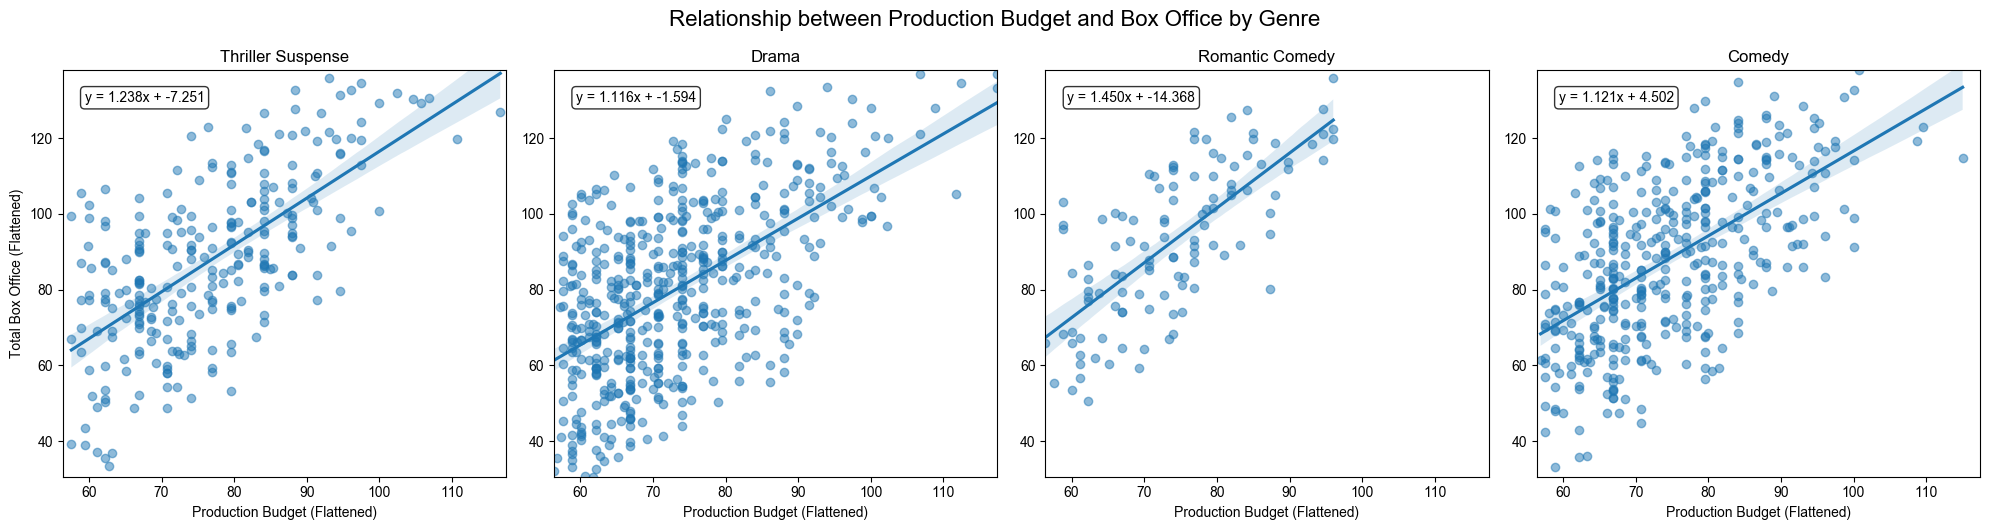

In [1274]:
# 繪製各類型的回歸分析圖
genres = ['T_Thriller_Suspense', 'T_Drama', 'T_Romantic_Comedy', 'T_Comedy']
filtered_df['T_Drama'] = 1 - filtered_df['T_Comedy'] - filtered_df['T_Thriller_Suspense'] - filtered_df['T_Romantic_Comedy']

# 設定圖表大小和標題
plt.figure(figsize=(20, 5))

# 計算所有資料的 y 軸範圍，確保所有圖表使用相同的 y 軸範圍
y_min = filtered_df['flattened_total_box_office'].min()
y_max = filtered_df['flattened_total_box_office'].max()
x_min = filtered_df['flattened_production_budget'].min()
x_max = filtered_df['flattened_production_budget'].max()

for i, genre in enumerate(genres, 1):
    plt.subplot(1, 4, i)
    genre_df = filtered_df[filtered_df[genre] == 1]
    
    # 執行回歸分析
    genre_model = sm.ols('flattened_total_box_office ~ flattened_production_budget', data=genre_df).fit()
    coef = genre_model.params['flattened_production_budget']
    r_squared = genre_model.rsquared
    
    # 繪製散點圖和回歸線
    sns.regplot(
        data=genre_df,
        x='flattened_production_budget',
        y='flattened_total_box_office',
        scatter_kws={'alpha': 0.5}
    )
    
    # 設定標題和標籤
    genre_name = genre.replace('T_', '').replace('_', ' ')
    plt.title(f'{genre_name}')
    plt.xlabel('Production Budget (Flattened)')
    plt.ylabel('Total Box Office (Flattened)' if i == 1 else '')
    
    # 設定 y 軸範圍
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    
    # 添加回歸線方程式
    intercept = genre_model.params['Intercept']
    equation = f'y = {coef:.3f}x + {intercept:.3f}'
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Relationship between Production Budget and Box Office by Genre', fontsize=16, y=1.05)
plt.show()